In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import fft
import wave
import sys
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import activations
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras import callbacks
from scipy.io.wavfile import write
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.io import wavfile
import scipy.signal as signal


In [2]:
path = 'C:/Users/User/Desktop/AppStat/MachineLearning/AppliedML2024/final_project/data/nsynth-test/audio/'

In [3]:
def read_wav_file(filename):
    with wave.open(filename, 'rb') as wf:
        params = wf.getparams()
        num_channels, sampwidth, framerate, num_frames = params[:4]
        frames = wf.readframes(num_frames)
        waveform = np.frombuffer(frames, dtype=np.int16)
    return waveform, params

def read_wav_file_scipy(filename):
    framerate, waveform = wavfile.read(filename)
    return waveform, framerate

def plot_waveform(waveform, framerate):
    # Create a time array in seconds
    time_array = np.arange(0, len(waveform)) / framerate
    plt.figure(figsize=(15, 5))
    plt.plot(time_array, waveform, label="Waveform")
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Waveform')
    plt.legend()
    plt.show()

def read_files_in_dir(directory):
    filenames = os.listdir(directory)
    return filenames


def pick_5_samples(arrays):
    instruments = []
    for array in arrays:
        pick = np.random.choice(array, 1)
        instruments.append(pick)
    return instruments

def pick_samples_and_classify(arrays):
    #Picks a random number of samples, and returns their filepath and label
    instruments = []
    #pick at minimum two instruments
    number_of_instruments = np.random.randint(2, len(arrays) + 1)
    labels = np.zeros(len(arrays))
    already_picked = []

    while len(instruments) < number_of_instruments:
        random_pick = np.random.randint(0, len(arrays))
        if random_pick in already_picked:
            break
        else:
            already_picked.append(random_pick)
            pick = np.random.choice(arrays[random_pick], 1)
            instruments.append(pick)
            labels[random_pick] = 1

    return instruments, labels
#read the filenames, and add their data to 5 lists
def add_waveform_to_list(filenames):
    waveforms = []
    for filename in filenames:
        waveform, params = read_wav_file_scipy(path + filename[0])
        waveforms.append(waveform)
    return waveforms
        
#Fast fourier transform
def fft_h(data, sample_rate):
    n = len(data)
    fft_data = np.fft.fft(data)
    freq = np.fft.fftfreq(n, d=1/sample_rate)
    return freq[:n//2], np.abs(fft_data[:n//2])

def normalize_waveform(waveform):
    return waveform

def combine_waveforms(waveforms):

    normalization =  1 / len(waveforms)
    out = np.zeros_like(waveforms[0], dtype=np.float32)
    for w in waveforms:
        out += w.astype(np.float32) * normalization
    return out # note, this retuns a float32 array - it is needed to convert this to int16 before saving it to a wav file
def waveform_to_wavfile(waveform, name_string, sample_rate = 16000):
    write(name_string, sample_rate, waveform.astype(np.int16))

def gen_combo_waveform():
    paths, label = pick_samples_and_classify([bass, guitar, flutes, keyboards])
    waveforms = add_waveform_to_list(paths)
    return combine_waveforms(waveforms), label, paths

def gen_data_set(N):
    data = []
    labels = []
    #paths = []
    for i in range(N):
        waveform, label, paths_f = gen_combo_waveform()
        f,t,zxx = signal.spectrogram(waveform)
      # _,_ ,zxx_path = signal.spectrogram(paths_f)
        data.append(zxx)
        labels.append(label)
        #f,t,zxx = signal.stft(waveform, fs=16000, nperseg=256)
    return data, labels

def gen_spectrogram_set_spectroy(N):
    data = []
    labels = []
    for i in range(N):
        paths, label = pick_samples_and_classify([bass, guitar, flutes, keyboards])
        waveforms = add_waveform_to_list(paths)
        freq, ts, spectro_data = signal.spectrogram(combine_waveforms(waveforms))

        inter_waveforms = []

        for waveform in waveforms:
            freq, ts, spectro = signal.spectrogram(waveform)
            inter_waveforms.append(spectro)
        
        data.append(spectro_data)
        labels.append(inter_waveforms)
    
    return data, labels
#Sorting the files in directory


filenames = read_files_in_dir(path)
#pianos = [filename for filename in filenames if "piano" in filename] #empty
bass = [filename for filename in filenames if "bass" in filename]
guitar = [filename for filename in filenames if "guitar" in filename]
#drum = [filename for filename in filenames if "drum" in filename] #empty
flutes = [filename for filename in filenames if "flute" in filename]
keyboards = [filename for filename in filenames if "keyboard" in filename] 



In [5]:
#Pick a random sample from each instrument list
waveforms = add_waveform_to_list(pick_5_samples([bass, guitar, flutes, keyboards]))




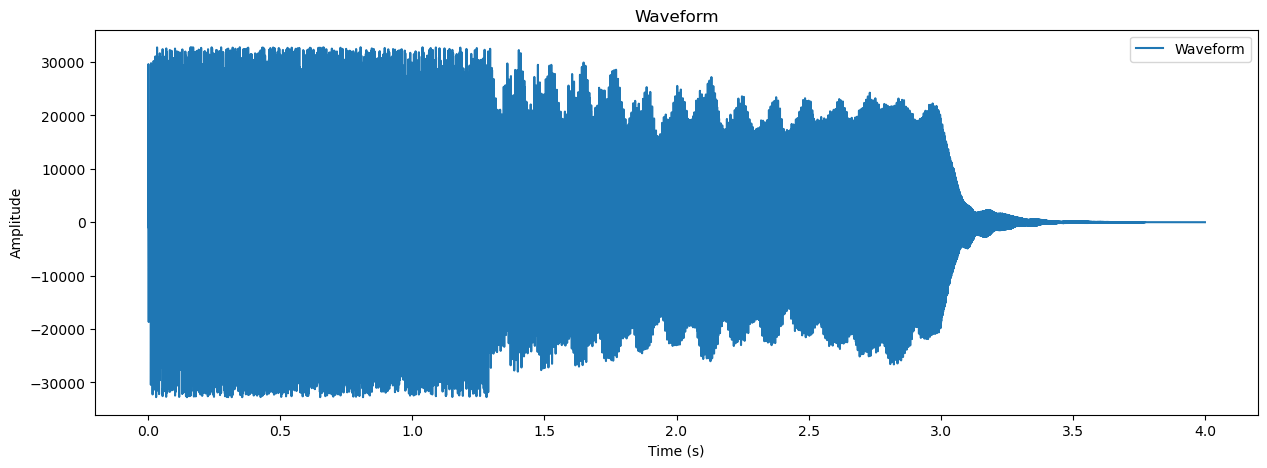

In [6]:
#Combine in a single list
combo = normalize_waveform(waveforms[0]) + normalize_waveform(waveforms[1]) +normalize_waveform(waveforms[2]) + normalize_waveform(waveforms[3])

sam_rate = 16000

plot_waveform(combo, sam_rate)


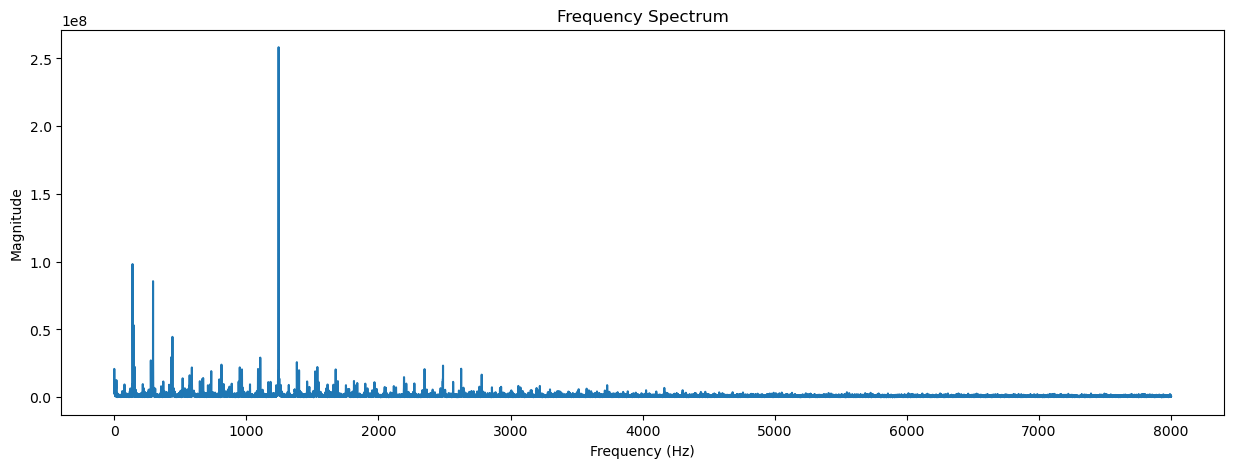

In [8]:
# Fast Fourier Transform (FFT) to convert the waveform to the frequency domain
def plot_fft(waveform, framerate):
    # Perform the FFT
    spectrum = fft.fft(waveform)
    freqs = fft.fftfreq(len(spectrum), 1 / framerate)
    # Plot the magnitude of the spectrum
    plt.figure(figsize=(15, 5))
    plt.plot(freqs[:len(freqs) // 2], np.abs(spectrum)[:len(freqs) // 2])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Frequency Spectrum')
    plt.show()

plot_fft(combo, sam_rate)


In [9]:
keybords_mask  = [filename for filename in filenames if "keyboard" in filename]
bass_mask = [filename for filename in filenames if "bass" in filename]
guitar_mask = [filename for filename in filenames if "guitar" in filename]



In [10]:

# combine the two masks
mask = keybords_mask + bass_mask + guitar_mask

In [10]:
# generate a datafile with the mask filenames and their labels, as an example 'keyboard_acoustic_004-034-075.wav', 'keyboard'
data = []
for filename in mask:
    label = filename.split('_')[0]
    data.append([filename, label])
df = pd.DataFrame(data, columns=['filename', 'label'])
df.to_csv('mask.csv', index=False)


In [11]:
# Convert the mask to frequency domain using FFT
import scipy.signal as signal
# using ShortTimeFFT to convert the waveform to the frequency domain


def read_wav_files(filenames):
    waveforms = []
    for filename in filenames:
        waveform, params = read_wav_file(data + filename)
        waveforms.append(waveform)
    return waveforms

def normalize_waveforms(waveforms):
    return [waveform / np.max(np.abs(waveform)) for waveform in waveforms]

def stft(waveform, framerate):
    f, t, Zxx = signal.stft(waveform, framerate, nperseg=1024)
    return f, t, Zxx

def plot_spectrogram(f, t, Zxx):
    plt.figure(figsize=(15, 5))
    plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

waveforms = read_wav_files(mask)
waveforms = normalize_waveforms(waveforms)
f, t, Zxx = stft(waveforms[0], sam_rate)
plot_spectrogram(f, t, Zxx)


TypeError: can only concatenate list (not "str") to list

In [ ]:
# Train a simple neural network to classify the mask catagories using the STFT data as input
# Load the data
df = pd.read_csv('mask.csv')
filenames = df['filename']
labels = df['label']
waveforms = read_wav_files(filenames)

# Normalize the waveforms
waveforms = normalize_waveforms(waveforms)

# Convert the waveforms to the frequency domain
X = []
for waveform in waveforms:
    f, t, Zxx = stft(waveform, sam_rate)
    X.append(np.abs(Zxx))
X = np.array(X)

# Convert the labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network
model = models.Sequential()
model.add(layers.Input(shape=(X.shape[1], X.shape[2])))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model implement early stopping
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stopping])




Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.5414 - loss: 0.9981 - val_accuracy: 0.6934 - val_loss: 0.6974
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.7349 - loss: 0.6557 - val_accuracy: 0.7624 - val_loss: 0.5887
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8444 - loss: 0.4319 - val_accuracy: 0.7956 - val_loss: 0.4805
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.8973 - loss: 0.3009 - val_accuracy: 0.8453 - val_loss: 0.3883
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9480 - loss: 0.1776 - val_accuracy: 0.8453 - val_loss: 0.3952
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9540 - loss: 0.1544 - val_accuracy: 0.8923 - val_loss: 0.3266
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9883 - loss: 0.0767 - val_accuracy: 0.8840 - val_loss: 0.3285
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9868 - loss: 0.0540 - val_accuracy: 0.

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9166 - loss: 0.5624
Loss: 0.5449233651161194, Accuracy: 0.9227373003959656


In [11]:


guitar = read_wav_file(path + 'guitar_acoustic_015-075-127.wav')[0]
keyboard = read_wav_file(path + 'keyboard_acoustic_004-045-025.wav')[0]
bass = read_wav_file(path + 'bass_electronic_018-029-075.wav')[0]
combo= combine_waveforms([keyboard, guitar, bass])
waveform_to_wavfile(combo,"combo.wav")


keyboard_acoustic_004-022-050.wav


In [ ]:
# Using the trained model to predict the mask of the mixed audio file
waveform, params = read_wav_file('combo.wav')
waveform = normalize_waveform(waveform)
f, t, Zxx = stft(waveform, sam_rate)
X = np.array([np.abs(Zxx)])
y_pred = model.predict(X)
y_pred = np.argmax(y_pred, axis=1)
label = label_encoder.inverse_transform(y_pred)
print(f'The predicted label is: {label[0]}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
The predicted label is: keyboard


In [ ]:
#Using gen_data_set to generate a dataset of 1000 samples
data, labels = gen_data_set(1000)
data = np.array(data)
labels = np.array(labels)
data[9].shape




(129, 285)

In [ ]:
# Find the shape of 1 element in the data
data.shape


(1000, 129, 501)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from scipy.signal import stft
from sklearn.metrics import f1_score
import tensorflow.keras.backend as K

#Using gen_data_set to generate a dataset of 1000 samples
# normalize the data with standard scaler
data, labels = gen_data_set(1000)
data = np.array(data)
labels = np.array(labels)
scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)


#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
# use 2d convolutional layers to classify the audio samples in data into the labels in labels
model = models.Sequential()
model.add(layers.Input(shape=(129,285, 1)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()




Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 127, 283, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 63, 141, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 61, 139, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 30, 69, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 28, 67, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 14, 33, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 59136)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │     7,569,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,672,676 (29.27 MB)

 Trainable params: 7,672,676 (29.27 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)
model.fit(X_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stopping])


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 614ms/step - accuracy: 0.5269 - loss: 0.1569 - val_accuracy: 0.4437 - val_loss: 0.8963
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 514ms/step - accuracy: 0.4909 - loss: 0.1853 - val_accuracy: 0.4313 - val_loss: 0.8826
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 497ms/step - accuracy: 0.4686 - loss: 0.1627 - val_accuracy: 0.4500 - val_loss: 0.9355
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 499ms/step - accuracy: 0.5314 - loss: 0.1401 - val_accuracy: 0.4375 - val_loss: 0.9983
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 504ms/step - accuracy: 0.5143 - loss: 0.1022 - val_accuracy: 0.4313 - val_loss: 1.1366
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 510ms/step - accuracy: 0.4705 - loss: 0.1112 - val_accuracy: 0.4125 - val_loss: 1.0871
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 504ms/step - accuracy: 0.5338 - loss: 0.0925 - val_accuracy: 0.4500 - val_loss: 1.1504
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 514ms/step - accuracy: 0.5667 - loss: 0.0657 - 

In [ ]:
# add a dimension to the data
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

y_pred = model.predict(X_test)
print(np.round(y_pred[:10]))
print(y_test[:10])

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
[[1. 1. 0. 0.]
 [1. 0. 1. 0.]
 [0. 0. 1. 1.]
 [0. 1. 1. 0.]
 [1. 1. 1. 1.]
 [0. 1. 1. 1.]
 [0. 1. 1. 0.]
 [0. 1. 1. 1.]
 [0. 1. 1. 1.]
 [1. 1. 0. 0.]]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 1. 1. 1.]
 [1. 0. 0. 1.]]


In [ ]:
def predict_instruments(wav_file, model, mlb):
    waveform, _ = read_wav_file(wav_file)
    #waveform = normalize_waveform(waveform)
    f, t, Zxx = stft(waveform, nperseg=1024)  # Adjust nperseg as necessary
    X = np.array([np.abs(Zxx)])
    y_pred = model.predict(X)[0]  # Get predictions for the first (and only) sample
    print("Predicted probabilities:", y_pred)
    threshold = 0.5  # Adjust as needed
    predicted_labels = mlb.classes_[y_pred > threshold]  # Select labels above the threshold
    return predicted_labels.tolist()  # Convert to list for consistent output format

# Predict the instruments in the mixed audio file
predicted_labels = predict_instruments('combo.wav', model, mlb)
print(f'The predicted labels are: {predicted_labels}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted probabilities: [0. 0. 1.]
The predicted labels are: ['keyboard']


In [ ]:
# Predict the instruments in the mixed audio file
predicted_labels = predict_instruments('combo.wav', model, mlb)
print(f'The predicted labels are: {predicted_labels}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The predicted labels are: [('keyboard',)]


### Unet approach


In [4]:
import numpy as np
from scipy import signal

def audio_to_spectrogram(audio, nperseg=2048, noverlap=512):
    if not np.issubdtype(audio.dtype, np.floating):
        audio = audio.astype(np.float32)
    freq,time ,spectrogram = signal.spectrogram(audio, nperseg=nperseg, noverlap=noverlap)
    #spectrogram = np.abs(spectrogram)
    return spectrogram.astype(np.float32)

def pad_spectrogram(spec, target_shape):
    padded_spec = np.zeros(target_shape)
    min_shape = np.minimum(target_shape, spec.shape)
    padded_spec[:min_shape[0], :min_shape[1]] = spec[:min_shape[0], :min_shape[1]]
    return padded_spec


def normalize_spectrogram(spec):
    return (spec - np.mean(spec)) / np.std(spec)

def pick_samples_and_classify(arrays):
    #Picks a random number of samples, and returns their filepath and label
    instruments = []
    #pick at minimum two instruments
    number_of_instruments = np.random.randint(2, len(arrays) + 1)
    labels = np.zeros(len(arrays))
    already_picked = []

    while len(instruments) < number_of_instruments:
        random_pick = np.random.randint(0, len(arrays))
        if random_pick in already_picked:
            break
        else:
            already_picked.append(random_pick)
            pick = np.random.choice(arrays[random_pick], 1)
            instruments.append(pick)
            labels[random_pick] = 1

    return instruments, labels
#read the filenames, and add their data to 5 lists
def add_waveform_to_list(filenames):
    waveforms = []
    for filename in filenames:
        waveform, params = read_wav_file_scipy(path + filename[0])
        waveforms.append(waveform)
    return waveforms

def combine_waveforms(waveforms):
    return np.sum(waveforms, axis=0)  # Combine waveforms by summing them. Brute force method, but it works


In [5]:
def gen_spectrogram_set_spectroy(N, target_shape=(129, 285), nperseg=2048, noverlap=512):
    data = []
    labels = []
    
    for i in range(N):
        paths, label = pick_samples_and_classify([bass, guitar, flutes, keyboards])
        waveforms = add_waveform_to_list(paths)
        mixed_waveform = combine_waveforms(waveforms)
        
        mixed_spectro = audio_to_spectrogram(mixed_waveform, nperseg, noverlap)
        mixed_spectro_padded = pad_spectrogram(mixed_spectro, target_shape)
        mixed_spectro_normalized = normalize_spectrogram(mixed_spectro_padded)
        
        inter_waveforms = []
        for waveform in waveforms:
            spectro = audio_to_spectrogram(waveform, nperseg, noverlap)
            spectro_padded = pad_spectrogram(spectro, target_shape)
            spectro_normalized = normalize_spectrogram(spectro_padded)
            inter_waveforms.append(spectro_normalized)
        
        data.append(mixed_spectro_normalized)
        labels.append(inter_waveforms)
    
    data = np.array(data)
    
    # Determine the maximum number of sources
    max_sources = max(len(label) for label in labels)
    
    # Pad or truncate each label array to have the same number of sources
    for i in range(len(labels)):
        while len(labels[i]) < max_sources:
            labels[i].append(np.zeros(target_shape))  # Pad with zeros
        if len(labels[i]) > max_sources:
            labels[i] = labels[i][:max_sources]  # Truncate to max_sources
    
    labels = np.array(labels)
    
    return data, labels


In [6]:
target_shape = (129, 285)
N = 1000  # Number of samples

data, labels = gen_spectrogram_set_spectroy(N, target_shape)

print(data.shape)  # Should be (N, 1025, 128)
print(labels.shape)


(1000, 129, 285)
(1000, 4, 129, 285)


In [7]:
# Write a multi-source audio seperation function using a unet model from torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

class AudioDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
class UNet(nn.Module):
    def __init__(self,input_channels = 1,output_channels = 4):
        super(UNet, self).__init__()
        # Define the contracting/downsampling path
        self.conv1 = nn.Conv2d(input_channels, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # Add max pooling layers for downsampling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Define the expanding/upsampling path
        # Add transpose convolutional layers for upsampling
        self.upconv1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.conv3 = nn.Conv2d(32, 16, 3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(16, 8, 2, stride=2)
        self.conv4 = nn.Conv2d(24, 8, 3, padding=1)
        self.conv5 = nn.Conv2d(8, output_channels, 3, padding=1)

    def forward(self, x):
        # Contracting path
        x1 = F.relu(self.conv1(x))
        x2 = self.pool(F.relu(self.conv2(x1)))
        
        # Expanding path with skip connections
        x = self.upconv1(x2)
        x = F.interpolate(x, size=(x1.size(2), x1.size(3)), mode='bilinear', align_corners=True)
        x = torch.cat([x, x1], dim=1)
        x = F.relu(self.conv3(x))
        
        x = self.upconv2(x)
        x = F.interpolate(x, size=(x1.size(2), x1.size(3)), mode='bilinear', align_corners=True)
        # Before concatenation in forward method
        #print("Shape of x before concatenation:", x.shape)
        #print("Shape of x1 before concatenation:", x1.shape)
        x = torch.cat([x, x1], dim=1)
        #print("Shape of x after concatenation:", x.shape)
        x = F.relu(self.conv4(x))
        
        x = self.conv5(x)
        return x
# Split the data into training and testing sets
#data = data[..., np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print(y_train.shape)
X_train = np.expand_dims(X_train, axis=1)
X_test = np.expand_dims(X_test, axis=1)
print(X_train.shape)
# Create the datasets and dataloaders
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
#print(train_dataset[0][0].shape)

# Get a batch of data
inputs, targets = next(iter(train_loader))

# Print the shape of the inputs
print(inputs.shape)

(800, 4, 129, 285)
(800, 1, 129, 285)
torch.Size([32, 1, 129, 285])


In [8]:
# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_channels = X_train.shape[1]  # Get the number of input channels from the data
model = UNet(input_channels=input_channels,output_channels=4).to(device, dtype=torch.float32)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#print(model)
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X, y in train_loader:
        X, y = X.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)

        #print(f"Shape of x : {X.shape},Shape of y {y.shape}")
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)  # Accumulate loss
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}')

# Evaluate the model
model.eval()
losses = []
weights = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device, dtype=torch.float32), y.to(device, dtype=torch.float32)
        y_pred = model(X)
        loss = criterion(y_pred, y)
        losses.append(loss.item() * X.size(0))
        weights.append(X.size(0))

    

average_loss = sum(losses) / len(test_loader.dataset)
print(f'Average Loss: {average_loss:.4f}')
torch.save(model.state_dict(), 'your_model_weights.pth')


Epoch 1, Loss: 0.4682
Epoch 2, Loss: 0.3872
Epoch 3, Loss: 0.3639


In [32]:
import torch
import numpy as np
import scipy.signal as signal
import wave
import soundfile as sf
import librosa
# Initialize and load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(input_channels=1).to(device)
model.load_state_dict(torch.load('your_model_weights.pth', map_location=device))
model.eval()

# Load input audio data using wave
with wave.open('combo.wav', 'rb') as wf:
    input_audio = wf.readframes(-1)
    input_sr = wf.getframerate()

# Convert input audio to numpy array
input_audio = np.frombuffer(input_audio, dtype=np.int16)

# Compute spectrogram using scipy.signal.spectrogram
freqs, times, spectrogram = signal.spectrogram(input_audio, fs=input_sr)

# Convert spectrogram to PyTorch tensor
input_tensor = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float32)  # Add batch and channel dimensions

# Pass input through the model to get predictions
with torch.no_grad():
    output_tensor = model(input_tensor)

# Convert output tensor to numpy array and save as audio files
output_tensor = output_tensor.squeeze().cpu().numpy()
output_folder = "output_audio"
# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)


# Convert each source back from spectrogram to audio and save
for i, source in enumerate(output_tensor):
    # Convert the spectrogram back to audio
    audio = librosa.feature.inverse.mel_to_audio(source)
    # Save the audio in the specified folder
    sf.write(os.path.join(output_folder, f'source{i + 1}.wav'), audio, input_sr)
